# Run from bootstrap paths

Now we will use the initial trajectories we obtained from bootstrapping to run an MSTIS simulation. This will show both how objects can be regenerated from storage and how regenerated equivalent objects can be used in place of objects that weren't stored.

Tasks covered in this notebook:
* Loading OPS objects from storage
* Ways of assigning initial trajectories to initial samples
* Setting up a path sampling simulation with various move schemes
* Visualizing trajectories while the path sampling is running

In [1]:
%matplotlib inline

In [2]:
import openpathsampling as paths
import numpy as np
import math

# the openpathsampling OpenMM engine
import openpathsampling.engines.openmm as eng

### Loading things from storage

First we'll reload some of the stuff we stored before. Of course, this starts with opening the file.

In [3]:
old_store = paths.AnalysisStorage("ala_mstis_bootstrap.nc")

A lot of information can be recovered from the old storage, and so we don't have the recreate it. However, we did not save our network, so we'll have to create a new one. Since the network creates the ensembles, that means we will have to translate the trajectories from the old ensembles to new ensembles.

In [4]:
print("PathMovers:", len(old_store.pathmovers))
print("Engines:", len(old_store.engines))
print("Samples:", len(old_store.samples))
print("Trajectories:", len(old_store.trajectories))
print("Ensembles:", len(old_store.ensembles))
print("SampleSets:", len(old_store.samplesets))
print("Snapshots:", len(old_store.snapshots))
print("Networks:", len(old_store.networks))

PathMovers: 45
Engines: 3
Samples: 538
Trajectories: 509
Ensembles: 223
SampleSets: 502
Snapshots: 57816
Networks: 1


Loading from storage is very easy. Each store is a list. We take the 0th snapshot as a template (it doesn't actually matter which one) for the next storage we'll create. There's only one engine stored, so we take the only one.

In [5]:
# template = old_store.snapshots[0]
engine = old_store.engines['default']
mstis = old_store.networks[0]
sset = old_store.tag['sampleset']

### initialize engine
if we do not select a platform the fastest possible will be chosen but we explicitly request to use the one in the config file


In [6]:
#platform = 'CUDA'
#engine.initialize(platform)

print('Engine uses platform `%s`' % engine.platform)

Engine uses platform `None`


In [7]:
sset.sanity_check()

## Running RETIS

Now we run the full calculation. Up to here, we haven't been storing any of our results. This time, we'll start a storage object, and we'll save the network we've created. Then we'll run a new `PathSampling` calculation object.

In [8]:
# logging creates ops_output.log file with details of what the calculation is doing
#import logging.config
#logging.config.fileConfig("logging.conf", disable_existing_loggers=False)

In [9]:
storage = paths.storage.Storage("ala_mstis_production.nc", "w")

In [10]:
storage.snapshots.save(old_store.snapshots[0]);

Before we can sample we still need to set the actual `MoveScheme` which determines the
set of moves to apply to our set of samples and effectively doing the steps in
replica (sampleset) space. We pick the default scheme for mstis and feed it with
the engine to be used.

In [11]:
scheme = paths.DefaultScheme(mstis, engine)

and finally generate the `PathSampler` object to conduct the simulation.

In [12]:
mstis_calc = paths.PathSampling(
    storage=storage,
    sample_set=sset,
    move_scheme=scheme
)
mstis_calc.save_frequency = 10

Now everything is ready: let's run the simulation! The first step takes a little since all
necessary information, i.e. the engines, topologies, initial snapshots, ..., need to be
stored. Then the monte carlo steps will be performed.

In [13]:
mstis_calc.run(10000)

Working on Monte Carlo cycle number 200
Running for 5 minutes 18 seconds -  1.60 seconds per step
Estimated time remaining: 4 hours 21.13 minutes


AssertionError: Trajectory does not match ensemble for replica 18

In [16]:
sample = mstis_calc.sample_set[18]

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

In [22]:
phi = storage.cvs['phi']
psi = storage.cvs['psi']

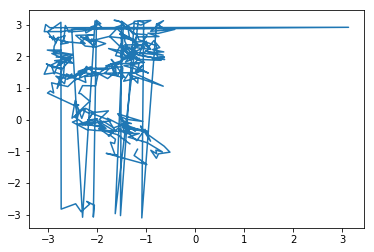

In [24]:
plt.plot(phi(sample), psi(sample), '-')

In [30]:
state_A = storage.volumes['A']
state_B = storage.volumes['B']
state_C = storage.volumes['C']
state_D = storage.volumes['D']

In [36]:
in_A = [s for s in sample.trajectory if state_A(s)]
in_D = [s for s in sample.trajectory if state_D(s)]

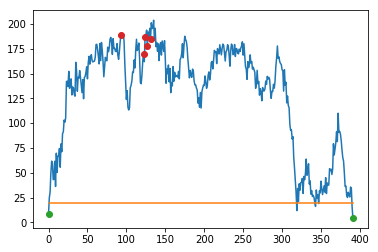

In [40]:
plt.plot(sample.ensemble.orderparameter(sample))
plt.plot([sample.ensemble.lambda_i] * len(sample.trajectory))
plt.plot([sample.trajectory.index(s) for s in in_D], sample.ensemble.orderparameter(in_D), 'o')
plt.plot([sample.trajectory.index(s) for s in in_A], sample.ensemble.orderparameter(in_A), 'o')

In [42]:
print(sample.ensemble)

(
  [
  (
    x[t] in {x|opD(x) in [0, 10]} for all t
  )
  and
  (
    len(x) = 1
  ),
  {x[t] in (not ({x|opD(x) in [0, 10]} or (({x|opA(x) in [0, 10]} or {x|opB(x) in [0, 10]}) or {x|opC(x) in [0, 10]}))) for all t} (OPTIONAL),
  (
    x[t] in ({x|opD(x) in [0, 10]} or (({x|opA(x) in [0, 10]} or {x|opB(x) in [0, 10]}) or {x|opC(x) in [0, 10]})) for all t
  )
  and
  (
    len(x) = 1
  )
  ]
)
and
(
  exists t such that x[t] in (not {x|opD(x) in [0, 20]})
)


In [ ]:
print len(storage.steps)

In [ ]:
# commented out during development, so we can "run all" and then do more
storage.close()